In [ ]:
import numpy as np
import matplotlib.pyplot as plt
mpy = np.random.random((9,16,16,2))-0.5
m = np.squeeze(mpy[:,:,:,0])
print(m.shape)

In [ ]:
figure = plt.figure(figsize=(10,10))
if len(m.shape)==3:
    for i in range(min(9, m.shape[0])):
        ax = figure.add_subplot(3,3,i+1)
        im = ax.matshow(np.squeeze(m[i,:,:]), cmap='RdBu_r')
        im.set_clim(0.001, 1.001)
    plt.tight_layout()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

data = np.arange(25).reshape(5,5)/4.0
figure = plt.figure(figsize=(10,10))
ax = figure.subplots()
im = ax.matshow(data, cmap='RdBu_r', clim=[0.0, 1.0])
norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)
figure.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='RdBu_r'))
for (i, j), z in np.ndenumerate(data):
    ax.text(j, i, '{:2.2f}'.format(z), ha='center', va='center',
    bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.show()

In [1]:
import model
import glob
import imageio
import time
import datetime
from IPython import display
import matplotlib.pyplot as plt
from iced import normalization
import cooler
import numpy as np
import copy

import tensorflow as tf
tf.keras.backend.set_floatx('float32')


# data from ftp://cooler.csail.mit.edu/coolers/hg19/
name = 'Dixon2012-H1hESC-HindIII-allreps-filtered.100kb.cool'
#name = 'Rao2014-K562-MboI-allreps-filtered.500kb.cool'
c = cooler.Cooler(name)
resolution = c.binsize
mat = c.matrix(balance=True).fetch('chr2')
idxy = ~np.all(np.isnan(mat), axis=0)
M = mat[idxy, :]
Mh = M[:, idxy]
Mh = Mh[0:1048, 0:1048]
print('MH: ', Mh.shape)


MH:  (1048, 1048)


In [8]:
def sampling_hic(hic_matrix, sampling_ratio):
    """sampling dense hic matrix"""
    m = np.matrix(hic_matrix)
    all_sum = m.sum(dtype='float')
    print(all_sum)
    idx_prob = np.divide(m, all_sum, out=np.zeros_like(m), where=all_sum!=0)
    idx_prob = np.asarray(idx_prob.reshape((idx_prob.shape[0]*idx_prob.shape[1],)))
    idx_prob = np.squeeze(idx_prob)
    print(idx_prob.shape)
    sample_number_counts = int(all_sum/sampling_ratio)
    print(m.shape)
    id_range = np.arange(m.shape[0]*m.shape[1])
    print(idx_prob)
    print(sample_number_counts)
    id_x = np.random.choice(id_range, size=sample_number_counts, replace=True, p=idx_prob)
    sample_m = np.zeros_like(m)
    for i in np.arange(sample_number_counts):
        x = int(id_x[i]/m.shape[0])
        y = int(id_x[i]%m.shape[0])
        sample_m[x,y] += 1.0
    return sample_m

7531394.07368584
(1098304,)
(1048, 1048)
[1.18696130e-04 1.12120832e-04 7.22454308e-05 ... 3.97147446e-05
 7.36363361e-05 7.12845995e-05]
1882848
ML:  (1048, 1048)


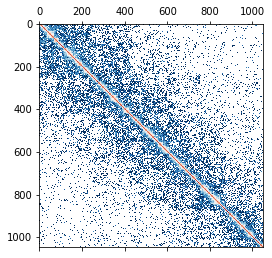

In [9]:
scale = 2
len_size = 512 
IMG_HEIGHT, IMG_WIDTH = int(Mh.shape[0]/scale), int(Mh.shape[1]/scale)
img_l = sampling_hic(Mh, scale**2)

Ml = img_l
print('ML: ', Ml.shape)
plt.matshow(np.log2(Ml), cmap='RdBu_r')


7531394.07368584
(1098304,)
(1048, 1048)
[1.18696130e-04 1.12120832e-04 7.22454308e-05 ... 3.97147446e-05
 7.36363361e-05 7.12845995e-05]
7531394
ML:  (1048, 1048)


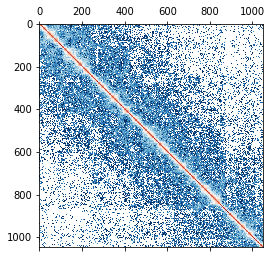

In [4]:
scale = 1
IMG_HEIGHT, IMG_WIDTH = int(Mh.shape[0]/scale), int(Mh.shape[1]/scale)
img_l = sampling_hic(Mh, scale**2)

Ml = img_l
print('ML: ', Ml.shape)
plt.matshow(np.log2(Ml), cmap='RdBu_r')

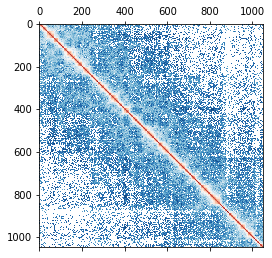

In [5]:
plt.matshow(np.log2(Mh), cmap='RdBu_r')

In [ ]:
# Normalization
Ml = normalization.SCN_normalization(Ml)
Mh = normalization.SCN_normalization(Mh)